In [2]:
!pip install plotly
!pip install numpy
!conda install -c plotly plotly-orca -y
!conda install psutil -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.5
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [16]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from utils.GeneticEngine import GeneticEngine

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='svg'

## Dataset
For this exercise we will be using the MNIST public dataset that consists of images of handwritten digits. This set is one of the most commonly used for testing different `Neural Network` model architectures.

Our goal is not to resolve the classification problem directly, but to find a very good set of hyperparameters using our genetic algorithm engine (`GeneticEngine`).

In [4]:
# Downloading and storing MNIST dataset in trainable mode.
dataset_train = MNIST('mnist', train=True, transform=ToTensor(), download=True)
dataset_test = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print(f'Total data train: {len(dataset_train)} test: {len(dataset_test)}',)

Total data train: 60000 test: 10000


## Model Definition
In this section we will be creating a neural network structure using `pytorch`. The idea behind this is to be able to modify the hyperparameters linked to this model. It is important to note that some parts of the architcture are fixed (number of hidden layers, activation functions). 

In [5]:
class FFNN(nn.Module):
  def __init__(self, input_size, h_1_size, h_2_size, h_3_size, output_size):
    super(FFNN, self).__init__()
    self.h_1 = torch.nn.Linear(input_size,h_1_size)
    self.h_2 = torch.nn.Linear(h_1_size,h_2_size)
    self.h_3 = torch.nn.Linear(h_2_size,h_3_size)
    self.h_4 = torch.nn.Linear(h_3_size,output_size)
  def forward(self, x):
    x = torch.nn.functional.relu(self.h_1(x))
    x = torch.nn.functional.relu(self.h_2(x))
    x = torch.nn.functional.relu(self.h_3(x))
    x = torch.nn.functional.relu(self.h_4(x))
    return x

In [6]:
# this is the collate_fn will be use to apply the needed transformations to our input

def custom_collate(batch):
  x_data = [x[0].view(28*28) for x in batch ]
  y_data = [ torch.tensor(x[1]) for x in batch ]

  return torch.stack(x_data),torch.stack(y_data)

In [7]:
def train(network, dataset, optimizer, epochs=1, batch_size=100, device='cpu', collate=None):
  network.to(device)
  criterion = nn.CrossEntropyLoss()
  data = DataLoader(dataset,batch_size=batch_size,shuffle=True,collate_fn=collate)
  loss, acc = [], []
  for e in range(1,epochs+1):
    acc_a = 0
    loss_a = 0
    for x, y in data:
      x, y = x.to(device).float(), y.to(device)
      y_pred = network(x)
      current_loss = criterion(y_pred,y)
      loss_a += current_loss.item()
      acc_a += torch.sum((torch.argmax(y_pred, 1) == y)).item()
      current_loss.backward()
      optimizer.step()
    print(f"Epoch: {e} | Acc: {acc_a/len(dataset)*100:.2f}% | loss: {loss_a/len(dataset)*batch_size:.3f}")
    acc.append(acc_a/len(dataset))
    loss.append(loss_a/len(dataset)*batch_size)
  return loss, acc

In [8]:
def test(network, dataset, batch_size=100, device='cpu', collate=None):
  network.to(device)
  data = DataLoader(dataset,batch_size=batch_size,shuffle=True,collate_fn=collate)
  criterion = nn.CrossEntropyLoss()
  acc_c = 0
  loss_c = 0
  with torch.no_grad():
    for x, y in data:
      x, y = x.to(device).float(), y.to(device)
      y_pred = network(x)
      loss_c += criterion(y_pred,y).item()
      acc_c += torch.sum((torch.argmax(y_pred, 1) == y)).item()
    print(f"\nTest Results: Acc: {acc_c/len(dataset)*100:.2f}% | loss: {loss_c/len(dataset)*batch_size:.3f}")
  return loss_c/len(dataset)*batch_size, acc_c/len(dataset)

## Getting Ready for GeneticEngine
Before using our `GeneticEngine` we need to create a way to encode our problem for it. For this we define several methods:
- Individual Generation: this method will be in charge of creating a new random valid individual.
- Mutate Individual: this method has the objective of randomly updating one allele of an individual.
- Fitness Function: this is one of the most important methods as it is responsible of evaluating how good (fit) an individual is.
- End Criteria: method used to determine when an individual that meets the acceptance criteria has been found.

In our particular case, we are using as a fitness factor the accuracy metric (in test) of our Neural Network Model, after being trained for 2 epochs with the current set of hyperparameters (individual).

There are several reasons why we did not include the number of epochs inside the gene, the main one being the complexity that can be added for higher values of this parameter. Besides this we do not use a single epoch to better observe the behaviour of the model between epochs. 

After this we can reinterpret the goal of this task as finding a set of hyperparameters that represent a very good starting point for a Neural Network Model that has a similar architecture.

As a secondary goal we are also optimizing parameters that are not entirely inside the neural network model but in the optimizer and the optimizer itself, for this we are using a `nominal` type of value.

We can notice that evaluating the fitness of an individual under this schema is incredibly expensive because it implies training and evaluating the model. For this reason, we are using a caching strategy based in the value of the hyperparameter set, this allows evaluating each hyperparameter set only once. We make this assumption based on the fact that even though running a neural network with the same set of hyperparameters not necessarily returns the same result, the difference between these results is not significant.

In [9]:
optimizer_options = [optim.Adam, optim.AdamW, optim.SGD, optim.RMSprop]

# cache structure to avoid re running model with same parameters twice
model_cache = {}

def decode_individual(individual):
  return {
    "h_1": individual[0],
    "h_2": individual[1],
    "h_3": individual[2],
    "optimizer": individual[3],
    "lr": individual[4],
    "batch_size": individual[5],
    "epochs": 10
  }

def fitness_method(individual):
  model_info = decode_individual(individual)
  
  cache_key = "_".join([str(v) for v in model_info.values()])
  
  if cache_key in model_cache:
    # print("cached")
    return model_cache[cache_key]

  model = FFNN(784,model_info["h_1"],model_info["h_2"],model_info["h_3"],10)
  model.train()
  optimizer = optimizer_options[model_info["optimizer"]](model.parameters(), lr=model_info["lr"])
  train(model,dataset_train,optimizer,epochs=2,collate=custom_collate)
  model.eval()
  test_loss, test_accuracy = test(model,dataset_test,collate=custom_collate)
  model_cache[cache_key] = test_accuracy

  return test_accuracy

In [10]:
def generate_individual():
  h_1_size = random.randint(1, 1500)
  h_2_size = random.randint(1, 1500)
  h_3_size = random.randint(1, 1500)
  optim = random.randint(0, 3)
  lr = random.uniform(1e-5,9e-4)
  batch_size = random.randint(1, 100)
  return [h_1_size,h_2_size,h_3_size,optim,lr,batch_size]

In [11]:
def mutate_individual(individual):
  idx_to_modify = random.randint(0, len(individual)-1)
  if idx_to_modify < 3:
    individual[idx_to_modify] = random.randint(1, 1500)
  elif idx_to_modify == 3:
    individual[idx_to_modify] = random.randint(0, 3)
  elif idx_to_modify == 4:
    individual[idx_to_modify] = random.uniform(1e-5,9e-4)
  else:
    individual[idx_to_modify] = random.randint(1, 100)
  return individual


In [12]:
def end_criteria(current_max_result):
  return current_max_result >= 0.92

In [13]:
GE = GeneticEngine(10,6,generate_individual,"tournament","crossover",mutate_individual,0.2,fitness_method,end_criteria)
GE.run(10)

Generation: 1
Evaluation
Epoch: 1 | Acc: 9.90% | loss: 2.303
Epoch: 2 | Acc: 9.92% | loss: 2.303

Test Results: Acc: 10.09% | loss: 2.303
Epoch: 1 | Acc: 19.27% | loss: 2.186
Epoch: 2 | Acc: 9.92% | loss: 2.303

Test Results: Acc: 10.09% | loss: 2.303
Epoch: 1 | Acc: 9.90% | loss: 2.303
Epoch: 2 | Acc: 9.92% | loss: 2.303

Test Results: Acc: 10.09% | loss: 2.303
Epoch: 1 | Acc: 10.44% | loss: 2.353
Epoch: 2 | Acc: 9.92% | loss: 2.303

Test Results: Acc: 10.09% | loss: 2.303
Epoch: 1 | Acc: 19.20% | loss: 2.102
Epoch: 2 | Acc: 19.36% | loss: 2.093

Test Results: Acc: 19.65% | loss: 2.099
Epoch: 1 | Acc: 11.33% | loss: 2.287
Epoch: 2 | Acc: 9.92% | loss: 2.303

Test Results: Acc: 10.09% | loss: 2.303
Epoch: 1 | Acc: 9.90% | loss: 2.362
Epoch: 2 | Acc: 9.92% | loss: 2.303

Test Results: Acc: 10.09% | loss: 2.303
Epoch: 1 | Acc: 56.02% | loss: 1.444
Epoch: 2 | Acc: 81.28% | loss: 0.563

Test Results: Acc: 83.53% | loss: 0.475
Epoch: 1 | Acc: 11.71% | loss: 2.284
Epoch: 2 | Acc: 9.92% | los

([1261, 466, 1447, 2, 0.0006249448596785886, 93], 0.9136)

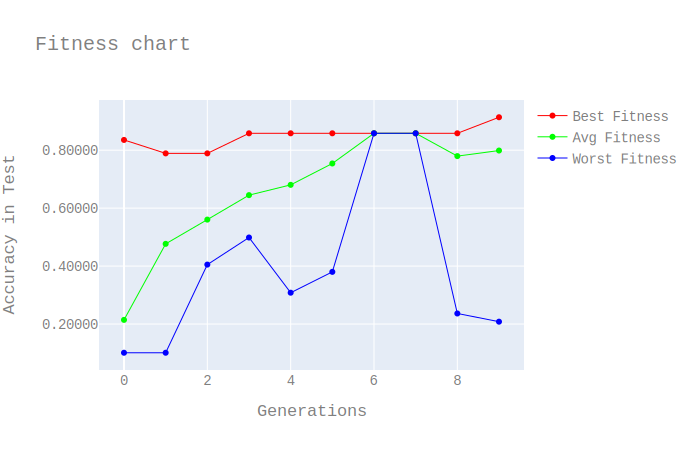

In [18]:
def create_figure():
    return go.Figure()
  
def plot_figure(fig, data, color, title):  
    
    y_axis = data
    fig.add_scatter(
        y=y_axis,
        mode="lines+markers", 
        textposition="bottom center",
        name=title,
        line={"color": color, "width": 1}
    )
    fig.update_layout(
        title="Fitness chart",
        xaxis_title="Generations",
        yaxis={"title": "Accuracy in Test", "tickformat": ".5f"},
        font=dict(
            family="Courier New, monospace",
            size=14,
            color="#7f7f7f"
        )
    )

fig = create_figure()

plot_figure(fig, GE.historic_max_metric, 'rgb(255,0,0)', 'Best Fitness')
plot_figure(fig, GE.historic_mean_metric, 'rgb(0,255,0)', 'Avg Fitness')
plot_figure(fig, GE.historic_min_metric, 'rgb(0,0,255)', 'Worst Fitness')
    
fig.show()



## Analyzing results
After testing with different configurations of population size and number of generations, we can conclude that using a genetic algorithm is a reasonable way to estimate a very good set of hyperparameters (it beats doing it manually), furthermore when training using specialized devices (GPU or TPU) are availbale. 

## Future Work
The next step is to increase the complexity of the Neural Network Model that is being optimized, testing with different activation functions (it can be implemented easily with a `nominal` strategy), different number of hidden layers or even the types of the layers. This could result in being able to use this project on more complex Neural Network architectures such as Convolutional or Recurrent Networks.